# Reinforcement Learning - Solving Escape Problems
Traditional escape problems have been extensively used in research related to data structures and algorithms. They serve as practical examples to demonstrate the use of multiple search algorithms, Dijkstra, A* search, and many more. **Reinforcement Learning** Escape problems are excellent for demonstrating and testing reinforcement learning techniques. Their familiar and intuitive nature makes them suitable for showcasing the capabilities of reinforcement learning algorithms.


<ol>
<li>The escape problem will be of <strong>size 5x5</strong></li>
<li>The agent <strong>START at the top left corner</strong> of the grid and the <strong>GOAL at the at cell 21</strong> of the grid, but if no coordinates are given the <strong>Class Agent</strong> will gereate a starting point at random.</li>
<li>In the middle of the grid we will generate some random obsticals.</li>
<li>We have two types of cells: free cells (white) and occupied cells (gray: For walls; Green: Goal; or Yellow: Agent).</li>
</ol>

# `Load Libraries`

<p>We will use the <strong>Pytorch</strong> Python deep learning library to perform the Reinforcement Learning  procees. <strong>Numpy</strong> used to hold, States, Q and V values. Also, we will need <strong>matplotlib</strong> module for drawing mazes.</p>


In [ ]:
# Array math
import numpy as np

# Iteration tracking
from tqdm import tqdm

# Type hinting
from typing import Tuple

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Os traversal
import os

from __future__ import print_function
import _datetime
import sys, time, datetime, json, random
# import random as rand
# from datetime import datetime
# from tensorflow import keras

import torch
from torch.autograd import Variable
from IPython.display import clear_output

import torch.nn as nn
import torch.nn.functional as F

import gym

%matplotlib inline
%load_ext tensorboard
%reload_ext tensorboard

For rendering Greek letters in Latex for plotting

In [ ]:
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams["text.latex.preamble"]  = r"\usepackage{cmbright}"
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***Rewards*** <u> Reward achieved: </u>  

* ***Reach goal(G):***
    * -1: For each step taken through transition from state A to A'. Used to find the shortest  path to GOAL
    

* ***Reach Walls()***:
    * -10 Penalizing the agent for running into a wall and leaving the agent in the same state before the action was taken

* ***Reach Open State()***:
    * 20: if GOAL is reached

***Action Space*** <u> Actions available: </u>  The action space is (list), where the *choose_action* function generates an np.random.choice INDEX use to decides direction to move in which can be:

- ***0: UP***

- ***1: DOWN***

- ***2: LEFT***

- ***3: RIGHT***

<h2 id="Actor Critic Equation">Actor Critic Equation<a </h2>

***Add the Actor Critic equation; learning; and architecture***


# Defining the ploting functions

- Gifs Animation Function
- Array Index to Matplot Coords Converter
- Maze Plotter
- Number of Visits Plotter
- Policy Plotter
- Q Table Plotter
- V Table Plotter



## Array Index to Matplot Coords Converter

In [ ]:
def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> Tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Maze Plotter

In [ ]:
def plot_matrix(
    M: np.array,
    goal_coords: list = [],
    hole_coords: list = [],
    start_coords: list = [],
    highlight_coords: list = [],
    img_width: int = 8,
    img_height: int = 8,
    title: str = None,
    filename: str = None,
    ) -> None:
    """
    Plots a matrix as an image.
    """
    height, width = M.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')

    for x in range(height):
        for y in range(width):
            # By default, the (0, 0) coordinate in matplotlib is the bottom left corner,
            # so we need to invert the y coordinate to plot the matrix correctly
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))
            # If there is a tuple of (x, y) in the hole_coords list, we color the cell salmon
            elif (x, y) in hole_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='salmon'))
            # If there is a tuple of (x, y) in the start_coords list, we color the cell yellow
            elif (x, y) in start_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))
            # If there is a tuple of (x, y) in the highlight_coords list, we color the cell lightblue
            elif (x, y) in highlight_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightblue'))

            ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')

    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

## Number of Visits Plotter

In [ ]:
def plot_state_visits(
        S: np.array,
        visit_dict: dict,
        img_width: int = 8,
        img_height: int = 8,
        ):
    """
    Plots the states and colors them by the number of visits.

    The more visits a state has, the darker the color.
    """
    # Get the number of rows and columns
    n_rows, n_cols = S.shape
    # Create a new matrix to hold the number of visits
    V = np.zeros((n_rows, n_cols))
    # Iterate through the visit dictionary and update the V matrix
    for s, visits in visit_dict.items():
        # Converting the state to an array index
        s_index = np.where(S == s)

        row, col = s_index[0][0], s_index[1][0]

        V[row, col] = visits

    fig = plt.figure(figsize=(img_width, img_height))
    ax = fig.add_subplot(111, aspect='equal')

    # Ploting the matrix
    sns.heatmap(V, cmap='Blues', cbar=False, annot=True, fmt='.0f', ax=ax)
    plt.show()

## Policy Plotter

In [ ]:
# Defining the ploting function for the policy
def plot_policy(
        S: np.ndarray,
        policy: list,
        goal_coords: tuple,
        wall_coords: list,
        start_coords: tuple,
        optimal_policy_path: list,
        title: str,
        img_width: int = 8,
        img_height: int = 8
        ):
    height, width = S.shape

    fig = plt.figure(figsize=(img_width, img_height))
    ax = fig.add_subplot(111, aspect='equal')
    for x in range(height):
        for y in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the hole_coords list, we color the cell gray
            if (x, y) in wall_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell yellow
            elif (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))

            else:
                try:
                    # If there is a tuple of (x, y) in the start_coords list, we color the cell green
                    if (x, y) in start_coords:
                        ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))

                        # Adding the arrows to the plot
                        if 0 == policy[optimal_policy_path.index((x, y))]:
                            plt.arrow(matplot_x, matplot_y, 0, 0.3, head_width = 0.05, head_length = 0.05)
                        if 1 == policy[optimal_policy_path.index((x, y))]:
                            plt.arrow(matplot_x, matplot_y, 0, -0.3, head_width = 0.05, head_length = 0.05)
                        if 2 == policy[optimal_policy_path.index((x, y))]:
                            plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                        if 3 == policy[optimal_policy_path.index((x, y))]:
                            plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)

                    elif (x, y) in optimal_policy_path:
                        ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightblue'))

                        # Adding the arrows to the plot
                        if 0 == policy[optimal_policy_path.index((x, y))]:
                            plt.arrow(matplot_x, matplot_y, 0, 0.3, head_width = 0.05, head_length = 0.05)
                        if 1 == policy[optimal_policy_path.index((x, y))]:
                            plt.arrow(matplot_x, matplot_y, 0, -0.3, head_width = 0.05, head_length = 0.05)
                        if 2 == policy[optimal_policy_path.index((x, y))]:
                            plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                        if 3 == policy[optimal_policy_path.index((x, y))]:
                            plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)
                except Exception as e:
                    print(f"Error: {e}")
                    print(f"Current x and y: {x}, {y}")

    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)

    plt.show()

## ActorCriticModel

Create a class for the NN Network with the number of inputs, Outputs, Hidden Layers

In [ ]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        """
        Initiate the ActorCritic NN
        @param n_input: input the number of states
        @param n_output: output n outputs base on number of actions
        @param n_hidden: a list of [FHL,2HL] with number of hidden nodes in 1rst layer and the 2nd layer
        """
        super(ActorCriticModel, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.action = nn.Linear(n_hidden[1], n_output) # obtain action from Moddle
        self.value = nn.Linear(n_hidden[1], 1) # Critic layer for Policy output one value

    def forward(self, x):
        x = torch.Tensor(x) # input layer from envioremnet
        x = F.relu(self.fc1(x)) # output of First layer
        x = F.relu(self.fc2(x)) # output of Second layer
        action_probs = F.softmax(self.action(x), dim=-1) # obtain action a by implementing a softMax from output layer (get softmax for a probability distribution)
        state_values = self.value(x) #Feed X back into the value layer to get the sate value
        return action_probs, state_values # Returns the Action probability and the State Value

# The policy and the movement rules

If an agent tries to move to a wall block, it will stay in the same state.

If the agent tries to go out of bounds - it will stay in the same state.

When the agent reaches its goal state, the episode terminates and the agent is returned to the starting state.

# The agent Class

The agent will be an object created by the class `Agent`. All the uptades of the q table will be done internally in the agent object.

In [ ]:

class Agent:
    def __init__(
        self,
        nrow_maze: int,
        ncol_maze: int,
        actions: list = [0, 1, 2, 3],
        walls_: list = [],
        start_state_ = None,
        goal_state_ = None,
        rewards: dict = {'step': -1, 'wall': -10, 'goal': 10 },
        gamma: float = 0.9,
        alpha: float = 0.05,
        epsilon: float = 0.1,
        seed: int = None,
        max_memory: int = 200 # max_memory - maximeal length of episodes to keep. When we reach the maximal lenght of memory, each time we add a new episode, the oldest episode is deleted
    ) -> None:


        """
        Creates an agent for the maze environment.

        Parameters
        ----------
        nrow_maze : int
            The number of rows in the maze.
        ncol_maze : int
            The number of columns in the maze.
        actions : list, optional
            A list of actions that the agent can take. The default is [0, 1, 2, 3].
            0: Up
            1: Down
            2: Left
            3: Right
        rewards : dict, optional
            A dictionary of rewards for the agent. The default is {'step': -1, 'wall': -10, 'goal': 10}.
        gamma : float, optional
            The discount factor. The default is 0.9.
        alpha : float, optional
            The learning rate. The default is 0.1.
        epsilon : float, optional
            The exploration rate. The default is 0.1.
        seed : int, optional
            The seed for the random generator. The default is 42.
        """


        self.nrow_maze = nrow_maze
        self.ncol_maze = ncol_maze

        self.maze_size = self.nrow_maze * self.ncol_maze

        # QsOpt: Generate a nparray shapre(n,) fopr Q Table
        self.QsOpt = np.zeros((self.nrow_maze, self.ncol_maze))  # Q Table

        self.rewards = rewards
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon

        self.seed = seed
        self.actions = actions

        # By default, the starting index is 0
        self.start_state = start_state_

        # Creating the random generator with a fixed seed; a replacement for RandomState
        self.random_generator = np.random.default_rng(self.seed)

        # Creating the maze; We will denote it internaly as S
        # This maze has a row x column size where each (r,w) = a state in the maze
        self.init_S_table()

        # Initiating the Q-table
        self.init_Q_table()

        # Saving the initial past_action and past_state
        self.past_action = None
        self.past_state = None

        # Creating the action name dictionary
        self.action_name_dict = {0: 'up', 1: 'down', 2: 'left', 3: 'right', }

        # Counter for the number of times our agent has seen the terminal state (GOAL)
        self.num_goal_reached = 0

        # Counter for each state and how many times the agent visited each
        self.state_visit_counter = {}

        # Empty dictionary of states visition paths
        self.state_visit_paths = {}

        # Empty dictionary of Q values
        self.Q_dict = {}

        # Placeholder for the current episode of learning; Default = 0
        self.current_episode = 0

        # Defining the path to intermediate images
        self.path_to_images_V = "q-learning-V-Table_Progress"

        # Defining the path to intermediate images
        self.path_to_images_Q = "q-learning-Q-Table_Progress"


        """
        My Changes:
        """

        self.num_actions = len(self.actions)
        self.n_hidden = [128, 32]

        self.gamma = 0.9
        self.epsilon = 1.0

        self.lr = 1e-3
        self.discount = self.gamma

        self.model = ActorCriticModel(self.maze_size, self.num_actions, self.n_hidden) # Initiate the ActorCritic Object. USE: self.maze_size, self.num_actions, self.n_hidden

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr) # Optimize the weights using Adam algorithm. USE: self.lr
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9) # Decays the learning rate of each parameter group by gamma every step_size epochs.

        self.loss = 0.0
        self.n_episodes = 0

        # Counter for steps to reach goal:
        self.Steps = 0

        # Counter for the number of times our agent hits a wall
        self.num_walls_hit = 0
        self.Episodes_rewards = 0.0

        # List for Ploting
        self.losses = []  # Append list of loss by episodes
        self.StepsToGoal = []  # Append list of number of steps it takes to reach GOAL by episodes
        self.rewards_q_learning = []  # Append list of rewards (OR USE np.zeros(episodes) if For Loop is available)
        self.WallsHit = []  # Append list of loss by episodes

        self.FinalLayerWeights_Actions = []  # Append list of last layer (before output) weights SUM (for each output)
        self.FinalLayerWeights_Critic = []  # Append list of last layer (before output) weights

        self.state_values = []

        self.Episodes_Actions = []

        self.walls_ = walls_

        # By default, the goal index is the last index
        self.goal_state = goal_state_


    def increment_state_visit(self, state) -> None:
        """
        Increments the state visit counter for the state.
        Called by get_next_state function
        """
        if state in self.state_visit_counter:
            self.state_visit_counter[state] += 1
        else:
            self.state_visit_counter[state] = 1

    def get_most_recent_action(self) -> str:
        """
        Returns the name of the most recent action.
        """
        return self.action_name_dict[self.past_action]

    def init_S_table(self):
        """
        Creates an internal S table where the rows of the table are
        the states and the columns are the actions.
        This maze has a row x column size where each (r,w) = a state in the maze
        """
        self.S = np.arange(0, self.nrow_maze * self.ncol_maze).reshape(self.nrow_maze, self.ncol_maze)

    def init_Q_table(self):
        """
        Creates an internal q table where the rows of the table are
        the states and the columns are the actions.
        """
        self.Q = np.zeros((self.S.size, len(self.actions)))

    def init_reward_dict(self):
        """
        Creates a dictionary where the keys are the states and the values are the rewards for transitioniting to that state.
        self.rewards.get() = gets the rewards for the steps | goal | or wall from Reward dictionary
            The get() method returns the value of the item with the specified key.
            if no rewards is found raise an error
        """
        if self.rewards.get('step') is None:
            raise ValueError("You must specify a reward for taking a step.")
        else:
            self.reward_dict = {s: self.rewards['step']for s in self.S.flatten()}

        if self.rewards.get('goal') is None:
            raise ValueError("You must specify a reward for reaching the goal state.")
        else:
            self.reward_dict[self.goal_state] = self.rewards['goal']

        if self.rewards.get('wall') is not None:
            # Setting the reward for the wall states
            for wall_state in self.wall_states:
                self.reward_dict[wall_state] = self.rewards['wall']

    def init_maze(self, maze_density: int = None):
        """
        Creates an array of states in a maze environment.

        Returns
        -------
        maze : np.array
            A 2D array of states in a maze environment.
        wall_coords : list
            A 1D array of wall states in the maze environment.
        start_coords: tuple
            A tuple of start coordinates in the maze environment.
        goal_coords: tuple
            A tuple of goal coordinates in the maze environment.
        """
        # If maze_density is None we will create walls in 20% of the maze
        if maze_density is None:
            maze_density = int(self.nrow_maze * self.ncol_maze * 0.2)

        # Creating the wall states
        wall_states = self.random_generator.choice(range(1, self.nrow_maze * self.ncol_maze), size=maze_density, replace=False)

        if not self.walls_:
            wall_states = wall_states
        else:
            wall_states = self.walls_

        # Getting the list of wall coordinates (Tuples r,c)
        wall_coords = [self.get_state_coords(s) for s in wall_states]

        # Generating a starting state from the states that are NOT walls
        # Find the set difference of two arrays. Return the unique values in array1 that are not in array2.
        start_state = self.random_generator.choice(np.setdiff1d(self.S, wall_states))

        if self.start_state is None:
            start_state = start_state
        else:
            start_state = self.start_state

        # Getting the starting coordinates
        start_coords = self.get_state_coords(start_state)

        # Generating a goal state from the states that are NOT walls and NOT the starting state
        # Find the set difference of two arrays. Return the unique values in array1 that are not in array2. (Not in WALL or Stating State)
        goal_state = self.random_generator.choice(np.setdiff1d(np.setdiff1d(self.S, wall_states), start_state))

        if self.goal_state is None:
            goal_state = goal_state
        else:
            goal_state  = self.goal_state

        # Getting the goal coordinates
        goal_coords = self.get_state_coords(goal_state)

        # Saving the wall coordinates, start coordinates, and goal coordinates
        self.wall_coords = wall_coords
        self.start_coords = [start_coords]
        self.goal_coords = [goal_coords]

        # Saving the indexes for the wall, start and goal states
        self.wall_states = wall_states
        self.start_state = start_state
        self.goal_state = goal_state

        # Initiating the reward dictionary
        self.init_reward_dict()

        # Initiating the agent
        self.init_agent()

    def get_state_index(self, row: int, col: int) -> int:
        """
        Returns the state index given the state coordinates.

        An inverse function of get_state_coords()
        """
        if (row < 0 or row >= self.nrow_maze or col < 0 or col >= self.ncol_maze):
            return -1
        else:
            return self.S[row][col]

    def get_state_coords(self, s) -> tuple:
        """
        Returns the state coordinates given the state index
            if the value s not in State S return -1,-1 (outside grid)
        """
        # Tuple of list with index of value s in State S
        s_index = np.where(self.S == s)
        if len(s_index[0]) == 0:
            return -1, -1

        return s_index[0][0], s_index[1][0]


    def init_agent(self):
        """
        We will set the past state and past action as the starting state and action
        """
        # Setting the previous state as the starting state
        self.past_state = self.start_state
        # self.past_action = self.get_epsilon_greedy_action(self.past_state)
        self.num_goal_reached = 0
        self.Steps = 0
        self.Episodes_rewards = 0.0
        self.num_walls_hit = 0

    # Logging of the agent paths
    def log_agent_move(self, state: int):
        """
        Logs the agent's move
            If the dictionary is empty add the current episode and the state visited
            else to the episode append the state(s) visited
        """
        if self.state_visit_paths.get(self.current_episode, None) is None:
            self.state_visit_paths[self.current_episode] = [state]
        else:
            self.state_visit_paths[self.current_episode].append(state)

    def get_next_state(self, s: int, action: int) -> int:
        """
        Given the current state and the current action, returns the next state index
        """
        # Getting the state coordinates
        s_row, s_col = self.get_state_coords(s)

        # Setting the boolean indicating that we have reached the terminal state
        reached_terminal = False
        # initiate rewards
        reward, max_Q = 0, 0

        # Getting the next state
        next_state = -1
        if action == 0:
            next_state = self.get_state_index(s_row - 1, s_col)
        elif action == 1:
            next_state = self.get_state_index(s_row + 1, s_col)
        elif action == 2:
            next_state = self.get_state_index(s_row, s_col - 1)
        elif action == 3:
            next_state = self.get_state_index(s_row, s_col + 1)

        # If next_state is a wall or the agent is out of bounds, we will stay in the same state
        if (next_state == -1) or (next_state in self.wall_states):
            # Incrementing the number of times we hit a wall
            self.num_walls_hit += 1

            # Getting the next_state's reward
            if (next_state == -1):
                # If the new state is the wall non-blocked space the rewards = wall and the max Q = o
                reward = self.rewards['wall']
                max_Q = 0
            else:
                # Getting the next_state's reward
                reward = self.reward_dict[next_state]
                new_state_Q_values = self.Q[next_state]
                # Getting the max Q value
                max_Q = np.max(new_state_Q_values)

            return s, reached_terminal, reward, max_Q

        # Incrementing the number of times we have visited the next state
        self.increment_state_visit(next_state)

        # If next_state is the goal state, we will return to the starting state
        if next_state == self.goal_state:
            # Incrementing the number of times our agent has reached the goal state
            self.num_goal_reached += 1
            reached_terminal = True
            max_Q = 0
        else:# Else we get the max Q value for the new state
            new_state_Q_values = self.Q[next_state]
            # Getting the max Q value
            max_Q = np.max(new_state_Q_values)

        reward = self.reward_dict[next_state]

        # Returning the next state
        return next_state, reached_terminal, reward, max_Q

    # PolicyNetwork
    def predict(self, s): # Call the ActorCritic Model
        """
        Compute the output using the Actor Critic model
        @param s: input state
        @return: action probabilities, state_value
        """
        return self.model(torch.Tensor(s)) # torch.from_numpy(np.array([new_state_x, new_state_y])).float() # might need to use new_state_Q_values[0] to assign new Qvalue

    def get_action(self, s) -> int:
        """
        Returns a random action from the set of actions

        Estimate the policy and sample an action, compute its log probability
        @param s: input state
        @return: the selected action, log probability, predicted state-value

        The actions are:
        0: up
        1: down
        2: left
        3: right
        """
        action_probs, state_value = self.predict(s) # Call the Predic fucntionc to get the new Action probability and the State Value
        action = torch.multinomial(action_probs, 1).item() # Returns a tensor where each row contains num_samples  indices sampled from the multinomial probability distribution located in the corresponding row of tensor input.
        log_prob = torch.log(action_probs[action]) #Returns a new tensor with the natural logarithm of the elements of input

        return action, log_prob, state_value

    def update(self, returns, log_probs, state_values):
        """
        Update the weights of the Actor Critic network given the training samples
        @param returns: return (cumulative rewards) for each step in an episode (GT)
        @param log_probs: log probability for each step
        @param state_values: state-value for each step (trajectory of predicted state-value at each step)
        """
        loss = 0
        for log_prob, value, Gt in zip(log_probs, state_values, returns):

            advantage = Gt - value.item()

            policy_loss = -log_prob * advantage # Policy gradient loss (#add negative sign since we are performing gradient ascent)

            value_loss = F.smooth_l1_loss(value, Gt) # Calculate the L1_loss of the State Value (instead of calculate MSE loss) (It is less sensitive to outliers than torch.nn.MSELoss and in some cases prevents exploding gradients)

            loss += policy_loss + value_loss # combine the policy_loss and value_loss to generate the loss value used to backpropogate the NN weight update.

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.losses.append(loss.detach().numpy())# Appending loss to plot smooth_l1_loss (NOT MSE)
        # APPEND THE WEIGHTS TO A LIST:
        self.FinalLayerWeights_Actions.append([self.model.state_dict()['action.weight'].detach().numpy()[0].sum(),
                                       self.model.state_dict()['action.weight'].detach().numpy()[1].sum(),
                                       self.model.state_dict()['action.weight'].detach().numpy()[2].sum(),
                                       self.model.state_dict()['action.weight'].detach().numpy()[3].sum()])

        self.FinalLayerWeights_Critic.append(self.model.state_dict()['value.weight'].detach().numpy().sum())

        # APPEND THE WEIGHTS TO A LIST: self.model.parameters()


    # Agent learning functions using Actor Critic
    def train_ActorCriticNN(self, num_episodes: int):
        """
        Actor Critic algorithm
        @param env: Gym environment
        @param estimator: policy network
        @param n_episode: number of episodes
        @param gamma: the discount factor
        """
        for episode in range(num_episodes):
            log_probs = []
            rewards = []
            state_values = []
            ep_actions = []

            self.init_agent() #env.reset() # self.start_state - Initiate agen t back to the starting possition

            while True:
                one_hot_state = [0] * self.maze_size # USER: self.mazesize
                one_hot_state[self.past_state] = 1 # starting place of the agent. USER: self.start_state
                action, log_prob, state_value = self.get_action(one_hot_state) # Calculate the action, Log_prob of action, and StateValue
                self.past_action = action
                # next_state, reward, is_done, _ = env.step(action) # next_state, reached_terminal, reward, max_Q = self.get_next_state(current_state, action)
                next_state, is_done, reward, max_Q = self.get_next_state(self.past_state, self.past_action)

                # total_reward_episode[episode] += reward
                self.Episodes_rewards += reward
                self.Steps += 1

                # Adding the next state to the path
                self.log_agent_move(next_state)

                log_probs.append(log_prob)
                state_values.append(state_value)
                rewards.append(reward)
                ep_actions.append(self.past_action)

                if is_done:

                    #Calculate Gt (cumulative discounted rewards)
                    returns = []

                    #track cumulative reward
                    Gt = 0
                    pw = 0

                    #iterate rewards from Gt to G0
                    for reward in rewards[::-1]: # start from the last appended r (LIFO)

                        #Recursive: G(t) = r(t) * G(t+1)^DISCOUNT
                        Gt += self.gamma ** pw * reward
                        pw += 1
                        returns.append(Gt) #add to front of Gt

                    returns = returns[::-1] # Reverse the order of Gt.
                    returns = torch.tensor(returns) # convert returns to tensor
                    returns = (returns - returns.mean()) / (returns.std() + 1e-9) # Transform the return to be used to updating.Transformation is called "whitening" because it changes the input vector into a white noise vector.


                    self.update(returns, log_probs, state_values) # Update the weight of the NN using the Cumm R(s,a), and LogProb & and StateVal calculated by the NN

                    # print('Episode: {}, total reward: {}, Action {}, State Value {}'.format(episode, self.Episodes_rewards, ep_actions, state_values)) # used for Debug
                    print('Episode: {}, total reward: {}'.format(episode, self.Episodes_rewards)) # used for Debug

                    if self.Episodes_rewards >= -12: # if accumulated reward of the episod is _ge_ 14 update the wieight
                        self.scheduler.step() # Call the .lr_scheduler.StepLR to decays the learning rate of each parameter group by gamma every step_size epochs.


                    # Appending Steps to Goal
                    self.StepsToGoal.append(self.Steps)

                    # Append walls HIT:
                    self.WallsHit.append(self.num_walls_hit)

                    # Appending Episodes total rewards
                    self.rewards_q_learning.append(self.Episodes_rewards)

                    #Append Policy
                    self.state_values.append(torch.tensor(state_values).detach().numpy())

                    # Append Ep Actions:
                    self.Episodes_Actions.append(ep_actions)

                    break

                # Setting the past_state as the next_state
                self.past_state = next_state

    def create_optimal_policy_path(self, policy):
        """
        Creates the path of the optimal policy, starting from the starting state
        """
        # Creating the policy path
        self.optimal_policy_path = [self.start_state]
        self.optimal_policy_path_coords = [self.get_state_coords(self.start_state)]

        # Getting the current state
        current_state = self.start_state

        # Policy
        self.policy = policy

        # Looping through the states
        for action in self.policy:
            self.past_action = action
            next_state, reached_terminal, reward, max_Q = self.get_next_state(current_state, self.past_action)

            # Adding the next state to the path
            self.optimal_policy_path.append(next_state)
            self.optimal_policy_path_coords.append(self.get_state_coords(next_state))

            # print(self.past_action,' ',next_state,' ',self.get_state_coords(next_state)) # For Debugging

            # Setting the current state as the next state
            current_state = next_state

        if current_state != self.goal_state:
            print('Policy is not optimal')

# Actor Critic Agent learning

First, let us create the agent object and initiate the maze environment for it.

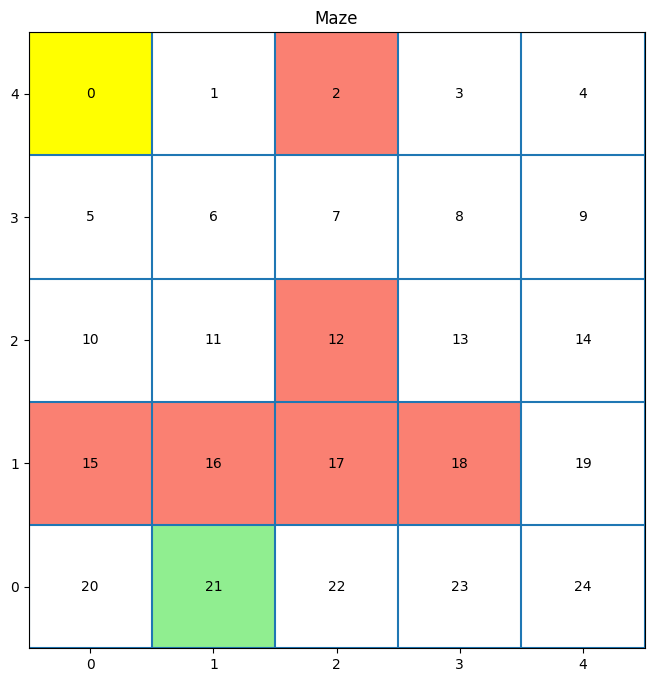

In [ ]:
agent = Agent(
    nrow_maze=5,
    ncol_maze=5,
    seed=42,
    walls_ = [2,12,15,16,17,18],
    start_state_ = 0,
    goal_state_ = 21,
    rewards={'step': -1, 'wall': -100, 'goal': -1, }

)

# Initiating the maze
agent.init_maze()
# agent.goal_state = 2
# Ploting the maze
plot_matrix(agent.S, goal_coords=agent.goal_coords, hole_coords=agent.wall_coords, start_coords=agent.start_coords, title="Maze")

# Actor Critic

## `Train agent`

In [ ]:
agent.train_ActorCriticNN(num_episodes=1000)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-8-091bc4d86825>:427: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, Gt) # Calculate the L1_loss of the State Value (instead of calculate MSE loss) (It is less sensitive to outliers than torch.nn.MSELoss and in some cases prevents exploding gradients)


Episode: 0, total reward: -5599.0
Episode: 1, total reward: -11639.0
Episode: 2, total reward: -18811.0
Episode: 3, total reward: -2769.0
Episode: 4, total reward: -5659.0
Episode: 5, total reward: -45213.0
Episode: 6, total reward: -21499.0
Episode: 7, total reward: -25831.0
Episode: 8, total reward: -10419.0
Episode: 9, total reward: -8001.0
Episode: 10, total reward: -33727.0
Episode: 11, total reward: -1229.0
Episode: 12, total reward: -13419.0
Episode: 13, total reward: -6987.0
Episode: 14, total reward: -4055.0
Episode: 15, total reward: -17035.0
Episode: 16, total reward: -5201.0
Episode: 17, total reward: -18875.0
Episode: 18, total reward: -16623.0
Episode: 19, total reward: -11971.0
Episode: 20, total reward: -41513.0
Episode: 21, total reward: -33109.0
Episode: 22, total reward: -19481.0
Episode: 23, total reward: -34077.0
Episode: 24, total reward: -47963.0
Episode: 25, total reward: -60923.0
Episode: 26, total reward: -2539.0
Episode: 27, total reward: -4377.0
Episode: 28,

# Plots
 - ***MSE Loss over all episodes***
 - ***Steps to Goal***
 - ***Rewards per Episodes***
 - ***Walls hits per Episodes***
 - ***Weights per Episodes***

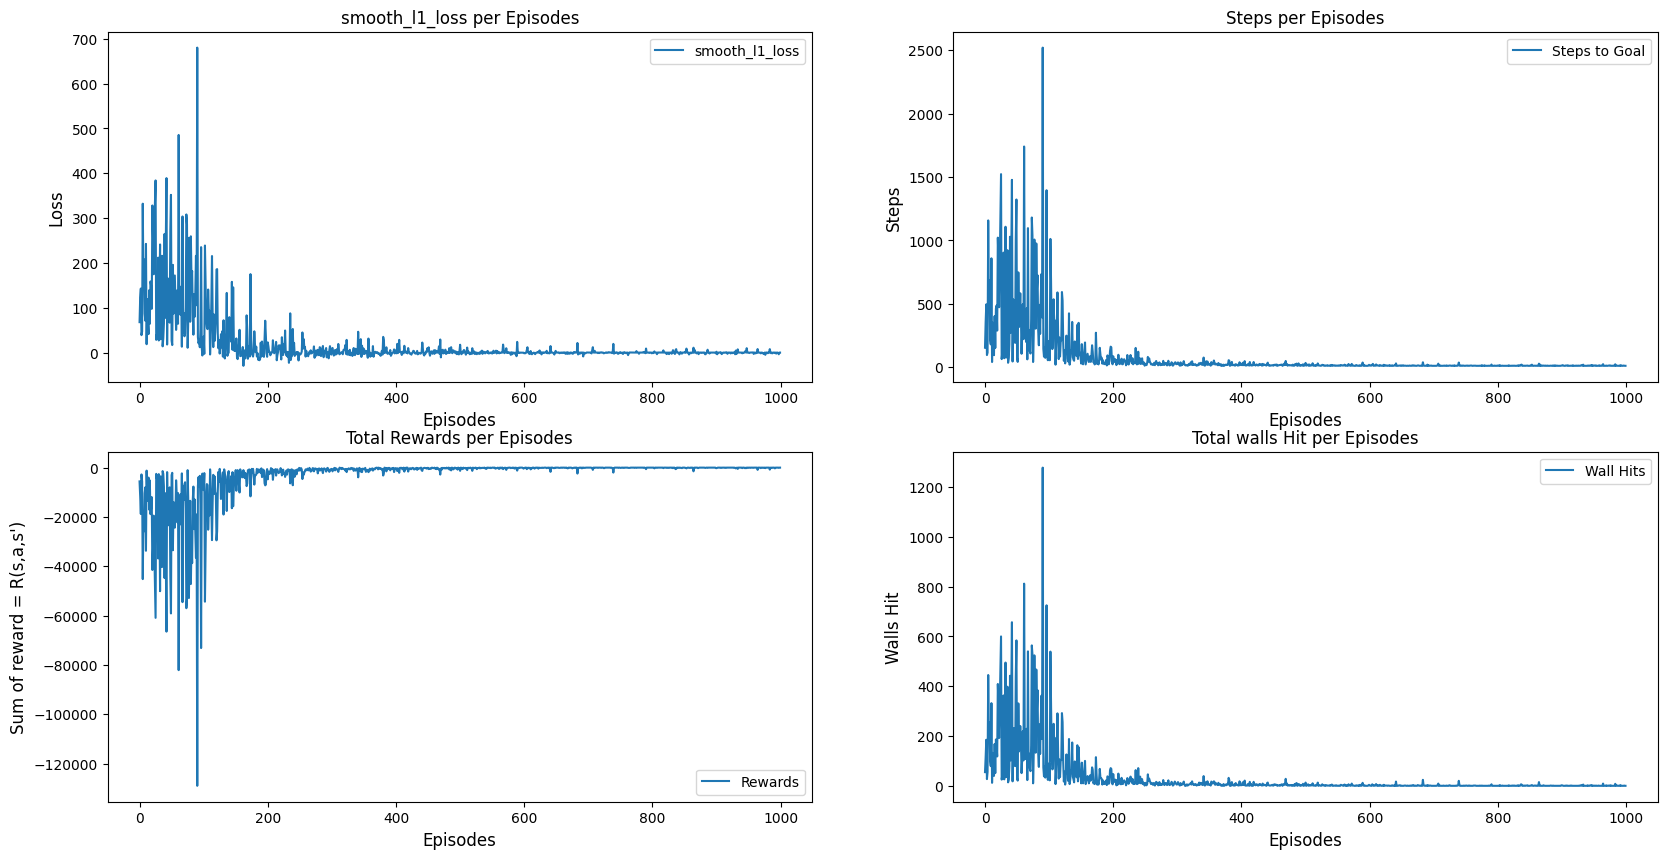

In [ ]:
# Plot the resutls:

plt.figure(figsize=(20, 10))
#MSE
plt.subplot(2, 2, 1)
plt.plot(agent.losses, label='smooth_l1_loss')
plt.xlabel("Episodes",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.legend()
plt.title('smooth_l1_loss per Episodes')

#Steps to Goal
plt.subplot(2, 2, 2)
plt.plot(agent.StepsToGoal, label='Steps to Goal')
plt.xlabel("Episodes",fontsize=12)
plt.ylabel("Steps",fontsize=12)
plt.legend()
plt.title('Steps per Episodes')

#Rewards
plt.subplot(2, 2, 3)
plt.plot(agent.rewards_q_learning, label='Rewards')
plt.xlabel("Episodes",fontsize=12)
plt.ylabel("Sum of reward = R(s,a,s')",fontsize=12)
plt.legend()
plt.title('Total Rewards per Episodes')

#Rewards
plt.subplot(2, 2, 4)
plt.plot(agent.WallsHit, label='Wall Hits')
plt.xlabel("Episodes",fontsize=12)
plt.ylabel("Walls Hit",fontsize=12)
plt.legend()
plt.title('Total walls Hit per Episodes')

# plt.tight_layout()
plt.show()

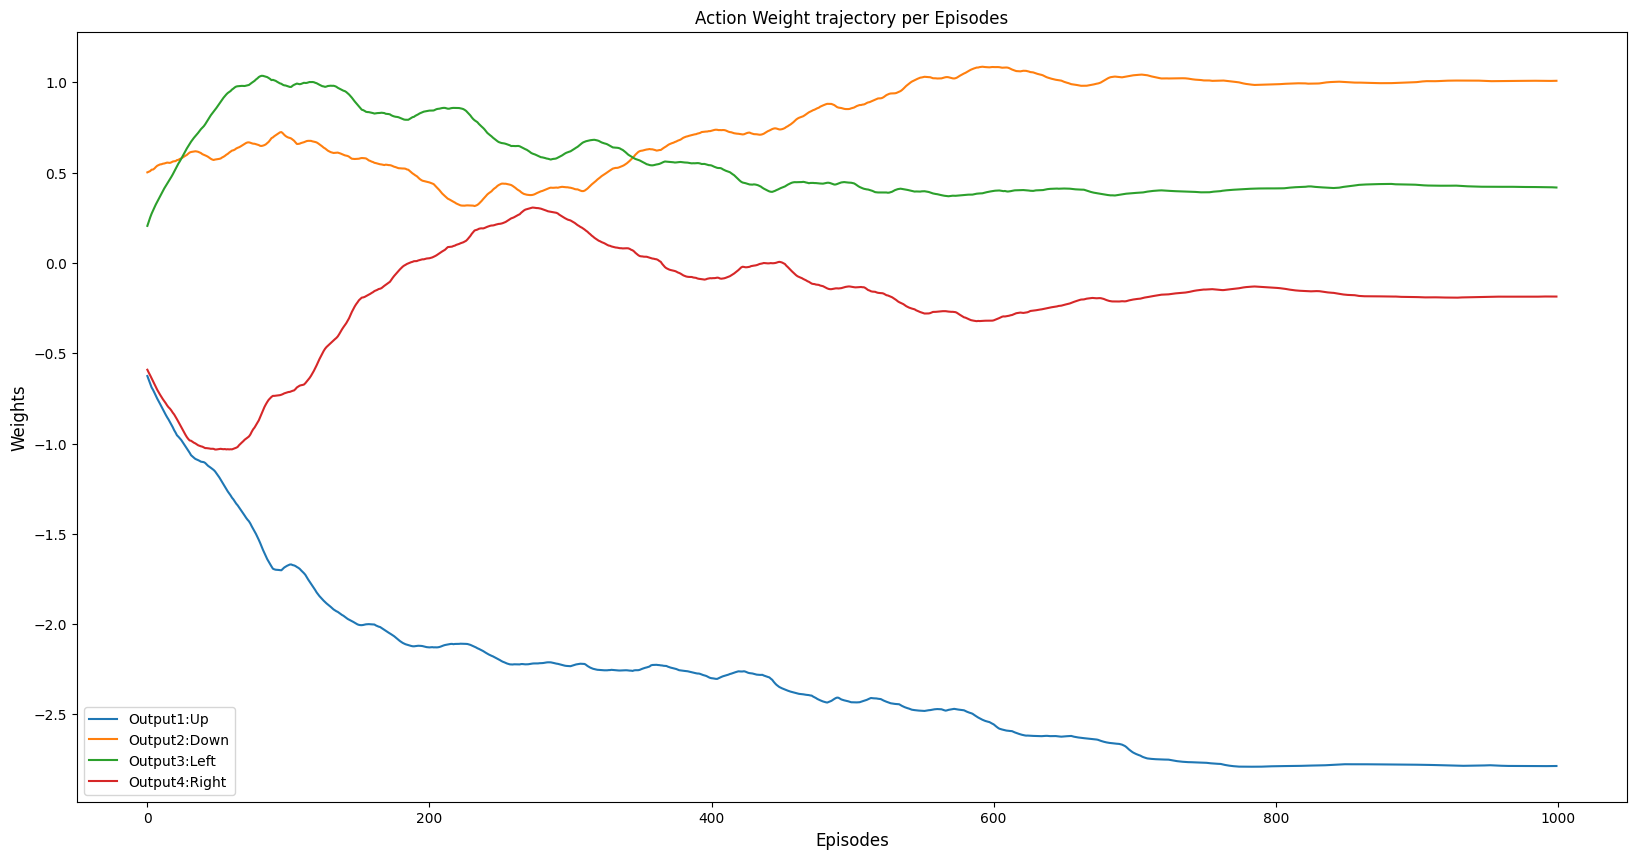

In [ ]:
# # Plot Weight Trajectories

x = agent.FinalLayerWeights_Actions
x = np.array(x)

x0 = x[:, 0]
x1 = x[:, 1]
x2 = x[:, 2]
x3 = x[:, 3]

plt.figure(figsize=(20, 10))

plt.subplot(1, 1, 1)
plt.plot(x0, label='Output1:Up')
plt.plot(x1, label='Output2:Down')
plt.plot(x2, label='Output3:Left')
plt.plot(x3, label='Output4:Right')

plt.xlabel("Episodes",fontsize=12)
plt.ylabel("Weights",fontsize=12)
plt.legend()
plt.title('Action Weight trajectory per Episodes')




plt.show()

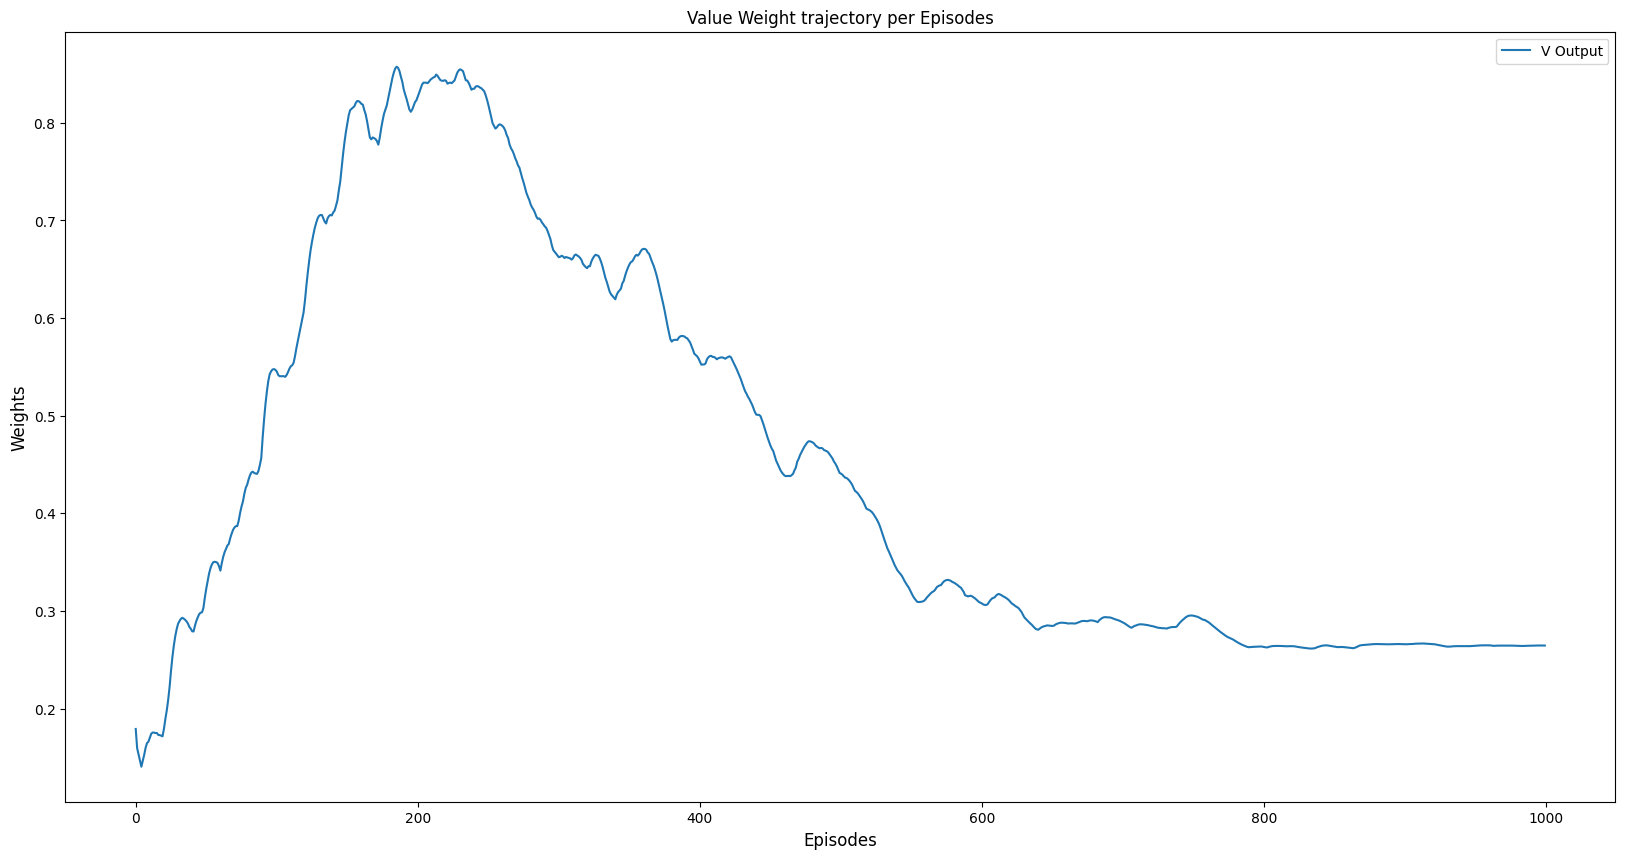

In [ ]:
# # Plot Weight Trajectories

y = agent.FinalLayerWeights_Critic


plt.figure(figsize=(20, 10))

plt.subplot(1, 1, 1)

plt.plot(y, label='V Output')


plt.xlabel("Episodes",fontsize=12)
plt.ylabel("Weights",fontsize=12)
plt.legend()
plt.title('Value Weight trajectory per Episodes')



plt.show()

Plot the optimal V table

In [ ]:
policy = None
for i in range(-1, -11,-1):
  if agent.rewards_q_learning[i] == -11:
    policy = agent.Episodes_Actions[i]

    break


In [ ]:
# Creating the optimal policy path
agent.create_optimal_policy_path(policy)

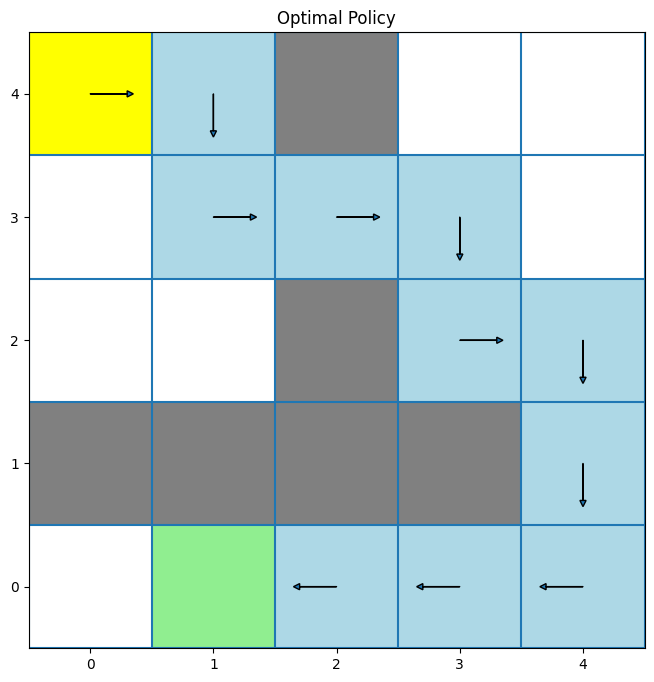

In [ ]:
plot_policy(
    S=agent.S,
    policy=agent.policy,
    optimal_policy_path=agent.optimal_policy_path_coords,
    goal_coords=agent.goal_coords,
    wall_coords=agent.wall_coords,
    start_coords=agent.start_coords,
    title="Optimal Policy"
    )

Plot the number of times each grid is visited over the training episodes

             Visited States


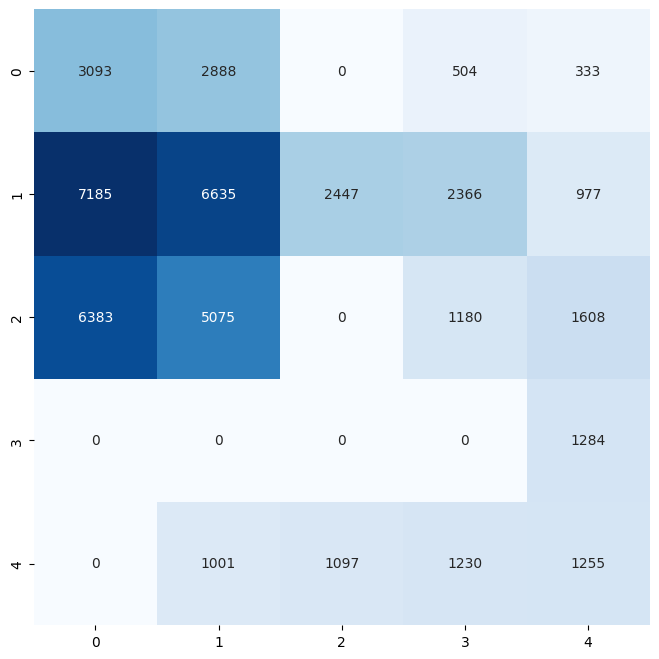

In [ ]:
print('             Visited States')
plot_state_visits(agent.S, agent.state_visit_counter)

***`Store the Policy in pickle for future use`***

In [ ]:
import pickle
f = open("GroupProject (Final).pkl","wb")
pickle.dump(policy, f)
f.close()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# References

1.   https://github.com/Eligijus112/rl-snake-game
2.   Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.




